# Models Testing on Heston data


In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
b_synthetic_calls_path = '../data/binom_synthetic_calls.csv'
b_synthetic_puts_path = '../data/binom_synthetic_puts.csv'
t_synthetic_calls_path = '../data/trinomial_synthetic_calls.csv'
t_synthetic_puts_path = '../data/trinomial_synthetic_puts.csv'

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [5]:
b_synthetic_calls = pd.read_csv(b_synthetic_calls_path, index_col=0)
b_synthetic_puts = pd.read_csv(b_synthetic_puts_path, index_col=0)
t_synthetic_calls = pd.read_csv(t_synthetic_calls_path, index_col=0)
t_synthetic_puts = pd.read_csv(t_synthetic_puts_path, index_col=0)

b_synthetic_calls = reduce_mem_usage(b_synthetic_calls)
b_synthetic_puts = reduce_mem_usage(b_synthetic_puts)
  
t_synthetic_calls = reduce_mem_usage(t_synthetic_calls)
t_synthetic_puts = reduce_mem_usage(t_synthetic_puts)
  
b_synthetic_calls = shuffle(b_synthetic_calls, random_state=0)
b_synthetic_puts = shuffle(b_synthetic_puts, random_state=0)
t_synthetic_calls = shuffle(t_synthetic_calls, random_state=0)
t_synthetic_puts = shuffle(t_synthetic_puts, random_state=0)

In [6]:
synthetic_options = pd.concat([b_synthetic_calls, 
                               b_synthetic_puts,
                               t_synthetic_puts,
                               t_synthetic_calls],
                              ignore_index=True)
synthetic_options = shuffle(synthetic_options, random_state=0)
synthetic_options = synthetic_options.reset_index()
synthetic_options = synthetic_options.drop('index', axis=1)

In [7]:
synthetic_options

,Price,Strike,Type,Vol,Interest Rate,Time to Expiration,Option Price
0,100,79.0,P,0.649902,0.099976,0.799805,8.992188
1,100,113.0,P,0.500000,0.070007,0.810059,23.046875
2,100,137.0,P,0.300049,0.029999,1.110352,38.031250
3,100,78.0,C,0.399902,0.090027,0.509766,27.421875
4,100,125.0,P,0.549805,0.090027,0.700195,29.640625
...,...,...,...,...,...,...,...
1113035,100,177.0,P,0.300049,0.049988,0.899902,69.687500
1113036,100,199.0,C,0.250000,0.099976,0.799805,0.029083
1113037,100,116.0,C,0.950195,0.020004,0.209961,11.796875
1113038,100,55.0,C,0.049988,0.010002,0.500000,45.281250


# Preprocessing

In [8]:
synthetic_options = pd.get_dummies(synthetic_options, prefix='', prefix_sep='')

In [9]:
input_sc = StandardScaler()
output_sc = StandardScaler()
input_data = input_sc.fit_transform(synthetic_options.drop('Option Price', axis=1))
output_data = output_sc.fit_transform(synthetic_options['Option Price'].values.reshape(-1, 1))

train_size = 0.8
val_size = 0.1

last_train_idx = int(np.round(len(input_data) * train_size))
last_val_idx = last_train_idx + int(np.round(len(input_data) * val_size))

X_train = input_data[0:last_train_idx]
X_val = input_data[last_train_idx:last_val_idx]
X_test = input_data[last_val_idx:]

y_train = output_data[0:last_train_idx]
y_val = output_data[last_train_idx:last_val_idx]
y_test = output_data[last_val_idx:]

In [10]:
X_train = Variable(torch.Tensor(X_train))
X_val = Variable(torch.Tensor(X_val))
X_test = Variable(torch.Tensor(X_test))

y_train = Variable(torch.Tensor(y_train))
y_val = Variable(torch.Tensor(y_val))
y_test = Variable(torch.Tensor(y_test))

# Model

In [11]:
CUDA = torch.cuda.is_available()
device = 'cuda:0' if CUDA else 'cpu'

In [12]:
class ResBlock(nn.Module):

  def __init__(self, module):
    super(ResBlock, self).__init__()
    self.module = module

  def forward(self, x):
    return self.module(x) + x

In [13]:
class HiddenLayer(nn.Module):

  def __init__(self, layer_size, act_fn):
      super(HiddenLayer, self).__init__()
      
      if act_fn == 'ReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ReLU())
      elif act_fn == 'LeakyReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.LeakyReLU())
      elif act_fn == 'ELU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ELU())
    
  def forward(self, x):
    return self.layer(x)

In [14]:
class Net(nn.Module):

  def __init__(self, input_size, output_size, hidden_size, num_layers, act_fn):
    super(Net, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size

    if act_fn == 'ReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ReLU())
    elif act_fn == 'LeakyReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.LeakyReLU())
    elif act_fn == 'ELU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ELU())

    self.hidden_layers_list = []

    for i in range(num_layers // 2):
      self.hidden_layers_list.append(
          ResBlock(
            nn.Sequential(
                HiddenLayer(self.hidden_size, act_fn),
                HiddenLayer(self.hidden_size, act_fn)
            )
        )
      )

    self.hidden_layers = nn.Sequential(*self.hidden_layers_list)

    self.net = nn.Sequential(
        self.initial_layer,
        self.hidden_layers,
        nn.Linear(self.hidden_size, self.output_size)
    )
  
  def forward(self, x):
    return self.net(x)

In [15]:
def init_weights(m, init_m: str):

  @torch.no_grad()
  def init_uniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_normal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xuniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xnormal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0.01)

  if init_m == 'uniform':
    m.apply(init_uniform)
  elif init_m == 'normal':
    m.apply(init_normal)
  elif init_m == 'xaiver uniform':
    m.apply(init_xuniform)
  elif init_m == 'xavier normal':
    m.apply(init_xnormal)

# Training

In [16]:
input_size = 7
output_size = 1
num_layers = 4
hidden_size = 600
batch_size = 1164
epochs = 2000
lr = 0.000109020874845956
init_method = 'xaiver uniform'
act_fn = 'LeakyReLU'

model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
init_weights(model, init_method)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
model = model.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [18]:
class OptDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return len(self.X)

### Losses Metrics

In [19]:
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output) / target))

In [20]:
def evaluate(model, loss_fn, X_val, y_val):
  model.eval()
  with torch.no_grad():
    out = model(X_val)
    loss = loss_fn(out, y_val)
    print('\nVal set: Average loss: {:.8f}\n'.format(
            loss.item()))
    return loss.item()

### Early Stopping class

In [21]:
# Code took form: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, 
                 patience=10, 
                 verbose=False, 
                 delta=0, 
                 path='../models/final_bintri_model.chkpt',
                 trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Train Loop

In [22]:
def train(
    epochs,
    batch_size,
    model,
    optimizer,
    loss_fn,
    X_train,
    y_train,
    X_val,
    y_val
):

  training_losses = []
  validation_losses = []

  early_stopping = EarlyStopping(patience=20)

  for epoch in range(epochs):
    model.train()
    epoch_losses = []
    total_loss = 0
    start_time = time.time()
    i = 0

    for batch, batch_labels in DataLoader(OptDataset(X_train, y_train), batch_size=batch_size):
      out = model(batch.to(device))
      optimizer.zero_grad()

      loss = loss_fn(out, batch_labels.to(device))
      epoch_losses.append(loss.item())
      total_loss += loss.item()
      loss.backward()
      optimizer.step()

      if i > 0 and i % 50 == 0:
        avg_loss = total_loss / 50
        elapsed = time.time() - start_time
        print('| Epoch {:3d} | {:5d}/{:5d} batches | lr {:2.5f} | ms/batch {:5.2f} | '
                  'loss {:5.8f}'.format(
              epoch, i, len(X_train) // batch_size+1, lr, elapsed * 1000 / 50,
              avg_loss))
        start_time = time.time()
        total_loss = 0

      i += 1

    training_losses.append(np.array(epoch_losses).mean())
    val_loss = evaluate(model, loss_fn, X_val, y_val)
    validation_losses.append(val_loss)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print(f"Stopping at Epoch: {epoch}")
        break

  return training_losses, validation_losses

In [23]:
load = False
save_model_path = '../models/final_bintri_model.chkpt'
val_err_df_path = '../results/val_final_bintri_model.csv'

if not load:
  train_losses, val_losses = train(
      epochs,
      batch_size,
      model,
      optimizer,
      loss_fn,
      X_train,
      y_train,
      X_val,
      y_val)
  val_err_df = pd.DataFrame({
      'Training': train_losses,
      'Validation': val_losses})
  val_err_df.to_csv(val_err_df_path)
  torch.save(model.state_dict(), save_model_path)
else:
  model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
  model.load_state_dict(torch.load(save_model_path, map_location=device))
  model = model.to(device)
  val_err_df = pd.read_csv(val_err_df_path, index_col=0)

| Epoch   0 |    50/  765 batches | lr 0.00011 | ms/batch 27.04 | loss 0.16184080
| Epoch   0 |   100/  765 batches | lr 0.00011 | ms/batch 22.28 | loss 0.00797154
| Epoch   0 |   150/  765 batches | lr 0.00011 | ms/batch 22.47 | loss 0.00271849
| Epoch   0 |   200/  765 batches | lr 0.00011 | ms/batch 26.20 | loss 0.00162771
| Epoch   0 |   250/  765 batches | lr 0.00011 | ms/batch 22.08 | loss 0.00125042
| Epoch   0 |   300/  765 batches | lr 0.00011 | ms/batch 23.61 | loss 0.00105664
| Epoch   0 |   350/  765 batches | lr 0.00011 | ms/batch 22.14 | loss 0.00095745
| Epoch   0 |   400/  765 batches | lr 0.00011 | ms/batch 22.45 | loss 0.00091641
| Epoch   0 |   450/  765 batches | lr 0.00011 | ms/batch 23.72 | loss 0.00084894
| Epoch   0 |   500/  765 batches | lr 0.00011 | ms/batch 21.76 | loss 0.00087101
| Epoch   0 |   550/  765 batches | lr 0.00011 | ms/batch 22.97 | loss 0.00082441
| Epoch   0 |   600/  765 batches | lr 0.00011 | ms/batch 22.41 | loss 0.00084786
| Epoch   0 |   

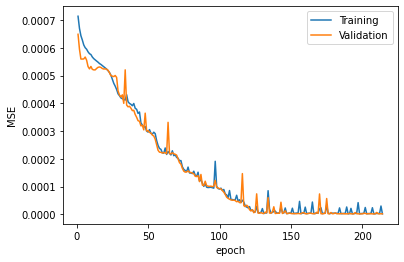

In [24]:
val_err_df[1:].plot(xlabel='epoch', ylabel='MSE')
plt.plot();

# Test the model

In [25]:
test_size = 30

with torch.no_grad():
    test_out = model(X_test[0:test_size])

test_out = output_sc.inverse_transform(test_out.cpu().detach().numpy())
real_out = output_sc.inverse_transform(y_test[0:test_size].cpu().detach().numpy())

In [26]:
cols = ['Price', 'Strike', 'Vol', 'Interest Rate', 'Time to Expiration', 'C', 'P', 'Prediction', 'Real']
test_options = pd.DataFrame(columns=cols)

In [27]:
for i, item in enumerate(input_sc.inverse_transform(X_test[0:test_size].cpu().detach().numpy())):
  opt = {
      'Price': item[0],
      'Strike': item[1],
      'Vol': item[2],
      'Interest Rate': item[3],
      'Time to Expiration': item[4],
      'C': item[5],
      'P': item[6],
      'Prediction': test_out[i][0],
      'Real': real_out[i][0]
  }
  test_options = test_options.append(opt, ignore_index=True)

In [28]:
test_options['Moneyness'] = test_options.Price / test_options.Strike
test_options['Abs Error'] = np.abs(test_options.Prediction - test_options.Real)

In [29]:
test_options.sort_values('Abs Error')

,Price,Strike,Vol,Interest Rate,Time to Expiration,C,P,Prediction,Real,Moneyness,Abs Error
20,100.0,115.000381,0.499985,0.019996,0.310060,0.0,1.0,20.437664,20.437771,0.869562,0.000107
22,100.0,133.002045,0.150030,0.070009,0.600106,0.0,1.0,27.611422,27.609835,0.751868,0.001587
6,100.0,80.004677,0.600081,0.059995,0.500014,0.0,1.0,6.275469,6.270766,1.249927,0.004704
15,100.0,50.008354,0.300119,0.070009,0.010166,1.0,0.0,50.044666,50.039757,1.999666,0.004910
29,100.0,51.015984,0.399962,0.029996,0.799831,0.0,1.0,0.247986,0.242970,1.960170,0.005016
10,100.0,133.002045,0.499985,0.029996,0.100026,0.0,1.0,32.866734,32.872910,0.751868,0.006176
3,100.0,153.987854,0.499985,0.099995,0.399921,0.0,1.0,49.943462,49.949791,0.649402,0.006329
9,100.0,174.993027,0.750098,0.059995,0.100026,0.0,1.0,74.089828,74.083458,0.571451,0.006371
5,100.0,70.005905,0.300119,0.090037,0.399921,0.0,1.0,0.101466,0.108019,1.428451,0.006554
12,100.0,125.997093,0.950217,0.099995,0.509746,1.0,0.0,20.304279,20.297197,0.793669,0.007082


### MSE on the test set

In [30]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = loss_fn(out, y_test)
    print('The MSE on the test set is: ', loss.item())

The MSE on the test set is:  1.8117501667802571e-06


### MAE on the test set

In [31]:
model.eval()
mae_loss = nn.L1Loss()
with torch.no_grad():
    out = model(X_test)
    loss = mae_loss(out, y_test)
    print('The MAE on the test set is: ', loss.item())

The MAE on the test set is:  0.0010656887898221612



### RSME on the test set

In [32]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = loss_fn(out, y_test)
    print('The RMSE on the test set is: ', np.sqrt(loss.item()))

The RMSE on the test set is:  0.0013460126919090537


### MAPE on the test set

In [33]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = MAPELoss(out, y_test).item()
    print('The MAPE on the test set is: ', loss)

The MAPE on the test set is:  0.005742945708334446


### $R^2$

In [34]:
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    out = model(X_test).squeeze().cpu().detach().numpy()

y_true = y_test.cpu().squeeze().detach().numpy()

r2 = r2_score(y_pred=out, y_true=y_true)

print('the R^2 score is: ', r2)

the R^2 score is:  0.9999981868649204


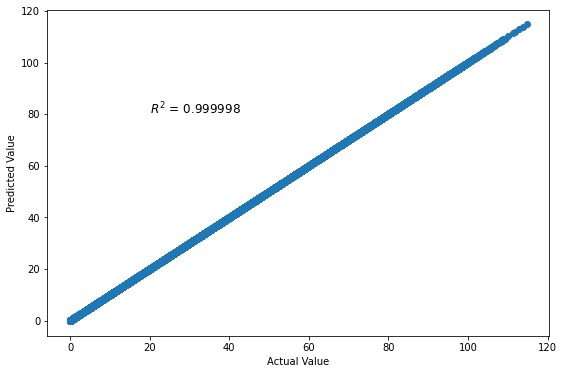

In [35]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()

ax.scatter(
    y=output_sc.inverse_transform(out.reshape(-1, 1)),
    x=output_sc.inverse_transform(y_true.squeeze().reshape(-1, 1))
)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')

ax.text(20, 80, f'$R^2$ = {np.round(r2, 6)}', fontsize=12)

plt.show()